In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis, skew
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# ---------------------
# 1) System Parameters
# ---------------------
SNR_dB = np.arange(-25, 6, 1)  # SNR range in dB
SNR_linear = 10 ** (SNR_dB / 10)

# Channel gains
h_u1_2 = 0.65
h_u2_2 = 2.7
h_oma_2 = 0.45

# Power allocation
alpha1 = 0.8
alpha2 = 0.2

# Detection parameters
Ns = 50
sigma_n2 = 1.0
alpha_cyclic = 0.1
Pf_u1 = Pf_u2 = Pf_oma = 0.10
M1, M2 = 2, 2

# Monte Carlo parameters
num_samples = 10000

# Machine learning parameters
test_size = 0.2

# Cyclic lags for CAF
cyclic_lags = [18, 15]


In [3]:
# ---------------------
# 2) Joint Judgment (Energy Detection) Functions
# ---------------------
def compute_lambda_joint(snr_db, alpha_1, alpha_2, M1, M2, Ns, Pf, sigma_n2):
    alpha_sum = alpha_1 + alpha_2
    if snr_db < -10:
        method = "OR"
        M = M1
    else:
        method = "AND"
        M = M2
    if method == "OR":
        extra_term = np.sqrt(-Ns * np.log(1 - (M1 * np.sqrt(1 - Pf)) / Ns)) if alpha_sum < 0.5 else np.sqrt(-Ns * np.log(Pf))
    elif method == "AND":
        extra_term = np.sqrt(-Ns * np.log(Pf) / M2) if alpha_sum < 0.5 else np.sqrt(-Ns * np.log(Pf))
    lambda_val = Ns + extra_term
    return lambda_val, method

def noma_downlink_pd_joint(SNR, alpha, h_2, Ns, lambda_val, sigma_n2):
    signal_power = alpha * h_2 * SNR
    return 1 - norm.cdf((lambda_val - Ns * (1 + signal_power)) / np.sqrt(2 * Ns * (1 + 2 * signal_power)))


In [ ]:
# ---------------------
# 3) Cyclic Correlation Detection Functions
# ---------------------
def compute_cyclic_threshold(Pf, Ns, sigma_n2):
    return np.sqrt(2 * sigma_n2 / Ns) * norm.ppf(1 - Pf)

def cyclic_correlation_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2, alpha_cyclic):
    signal_power = alpha * h_2 * SNR
    var_cyclic_H1 = (sigma_n2 + signal_power)**2 / Ns
    return 1 - norm.cdf((lambda_val - signal_power) / np.sqrt(var_cyclic_H1))


In [ ]:
# ---------------------
# 4) ML Data Generation and Logistic Regression
# ---------------------
def extract_features(received_signal):
    mag = np.abs(received_signal)
    caf_values = []
    for lag in cyclic_lags:
        if lag < Ns:
            caf = np.mean(received_signal[:-lag] * np.conj(received_signal[lag:]))
            caf_values.append(np.abs(caf))
    caf_peak = max(caf_values) if caf_values else 0.0
    caf_variance = np.var(caf_values) if len(caf_values) > 1 else 0.0
    signal_power = max(np.mean(mag ** 2) - sigma_n2, 0)
    mag_kurtosis = kurtosis(mag)
    mag_skewness = skew(mag)
    return [
        np.mean(mag),
        np.std(mag),
        np.sum(mag ** 2),
        np.percentile(mag, 25),
        np.percentile(mag, 75),
        caf_peak,
        caf_variance,
        signal_power,
        mag_kurtosis,
        mag_skewness
    ]

def generate_ml_data(snr_lin, num_samples):
    X, y = [], []
    for _ in range(num_samples):
        signal_present = np.random.rand() > 0.5
        if signal_present:
            x_u1 = np.sqrt(alpha1 * h_u1_2 * snr_lin) * np.random.randn(Ns)
            x_u2 = np.sqrt(alpha2 * h_u2_2 * snr_lin) * np.random.randn(Ns)
            signal = x_u1 + x_u2
        else:
            signal = np.zeros(Ns)
        noise = np.sqrt(sigma_n2 / 2) * (np.random.randn(Ns) + 1j * np.random.randn(Ns))
        received = signal + noise
        features = extract_features(received)
        X.append(features)
        y.append(signal_present)
    return np.array(X), np.array(y)

def train_logistic_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    y_probs = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc


In [ ]:
# ---------------------
# 5) Throughput Calculation Functions
# ---------------------
def calc_noma_rate_user(alpha, h_2, snr, interference_alpha, interference_h_2):
    numerator = alpha * h_2 * snr
    denominator = interference_alpha * interference_h_2 * snr + sigma_n2
    return np.log2(1 + numerator / denominator)


In [7]:
# ---------------------
# 6) Main Simulation
# ---------------------
th_noma_total_joint = []
th_noma_total_cyclic = []
th_noma_total_lr = []

for idx, snr_db in enumerate(SNR_dB):
    snr_lin = SNR_linear[idx]
    
    # Joint Judgment (Energy Detection)
    lambda_noma_joint, _ = compute_lambda_joint(snr_db, alpha1, alpha2, M1, M2, Ns, Pf_u1, sigma_n2)
    pd_u1_joint = noma_downlink_pd_joint(snr_lin, alpha1, h_u1_2, Ns, lambda_noma_joint, sigma_n2)
    pd_u2_joint = noma_downlink_pd_joint(snr_lin, alpha2, h_u2_2, Ns, lambda_noma_joint, sigma_n2)
    
    # Cyclic Correlation
    lambda_noma_cyclic = compute_cyclic_threshold(Pf_u1, Ns, sigma_n2)
    pd_u1_cyclic = cyclic_correlation_pd(snr_lin, alpha1, h_u1_2, Ns, lambda_noma_cyclic, sigma_n2, alpha_cyclic)
    pd_u2_cyclic = cyclic_correlation_pd(snr_lin, alpha2, h_u2_2, Ns, lambda_noma_cyclic, sigma_n2, alpha_cyclic)
    
    # Logistic Regression
    X, y = generate_ml_data(snr_lin, num_samples)
    fpr, tpr, _ = train_logistic_regression(X, y)
    fpr_desired = 0.10
    pd_lr = float(interp1d(fpr, tpr)(fpr_desired)) if max(fpr) >= fpr_desired else 1.0
    
    # Throughput calculations
    rate_u1 = calc_noma_rate_user(alpha1, h_u1_2, snr_lin, alpha2, h_u2_2)
    rate_u2 = calc_noma_rate_user(alpha2, h_u2_2, snr_lin, 0, 0)
    
    th_noma_total_joint.append(pd_u1_joint * rate_u1 + pd_u2_joint * rate_u2)
    th_noma_total_cyclic.append(pd_u1_cyclic * rate_u1 + pd_u2_cyclic * rate_u2)
    th_noma_total_lr.append(pd_lr * (rate_u1 + rate_u2))
    
    # Print progress
    print(f"SNR = {snr_db:3d} dB | Joint-Pd(U1/U2) = {pd_u1_joint:.3f}/{pd_u2_joint:.3f} | Cyclic-Pd(U1/U2) = {pd_u1_cyclic:.3f}/{pd_u2_cyclic:.3f} | LR-Pd = {pd_lr:.3f}")
    print(f"Throughput: Joint = {th_noma_total_joint[-1]:.3f}, Cyclic = {th_noma_total_cyclic[-1]:.3f}, LR = {th_noma_total_lr[-1]:.3f}\n")


SNR = -25 dB | Joint-Pd(U1/U2) = 0.144/0.144 | Cyclic-Pd(U1/U2) = 0.036/0.036 | LR-Pd = 0.110
Throughput: Joint = 0.001, Cyclic = 0.000, LR = 0.001

SNR = -24 dB | Joint-Pd(U1/U2) = 0.144/0.145 | Cyclic-Pd(U1/U2) = 0.036/0.036 | LR-Pd = 0.112
Throughput: Joint = 0.001, Cyclic = 0.000, LR = 0.001

SNR = -23 dB | Joint-Pd(U1/U2) = 0.145/0.145 | Cyclic-Pd(U1/U2) = 0.037/0.037 | LR-Pd = 0.112
Throughput: Joint = 0.001, Cyclic = 0.000, LR = 0.001

SNR = -22 dB | Joint-Pd(U1/U2) = 0.146/0.146 | Cyclic-Pd(U1/U2) = 0.037/0.037 | LR-Pd = 0.102
Throughput: Joint = 0.001, Cyclic = 0.000, LR = 0.001

SNR = -21 dB | Joint-Pd(U1/U2) = 0.147/0.148 | Cyclic-Pd(U1/U2) = 0.038/0.038 | LR-Pd = 0.121
Throughput: Joint = 0.002, Cyclic = 0.000, LR = 0.001

SNR = -20 dB | Joint-Pd(U1/U2) = 0.149/0.149 | Cyclic-Pd(U1/U2) = 0.039/0.039 | LR-Pd = 0.124
Throughput: Joint = 0.002, Cyclic = 0.001, LR = 0.002

SNR = -19 dB | Joint-Pd(U1/U2) = 0.151/0.151 | Cyclic-Pd(U1/U2) = 0.040/0.040 | LR-Pd = 0.105
Throughput: 

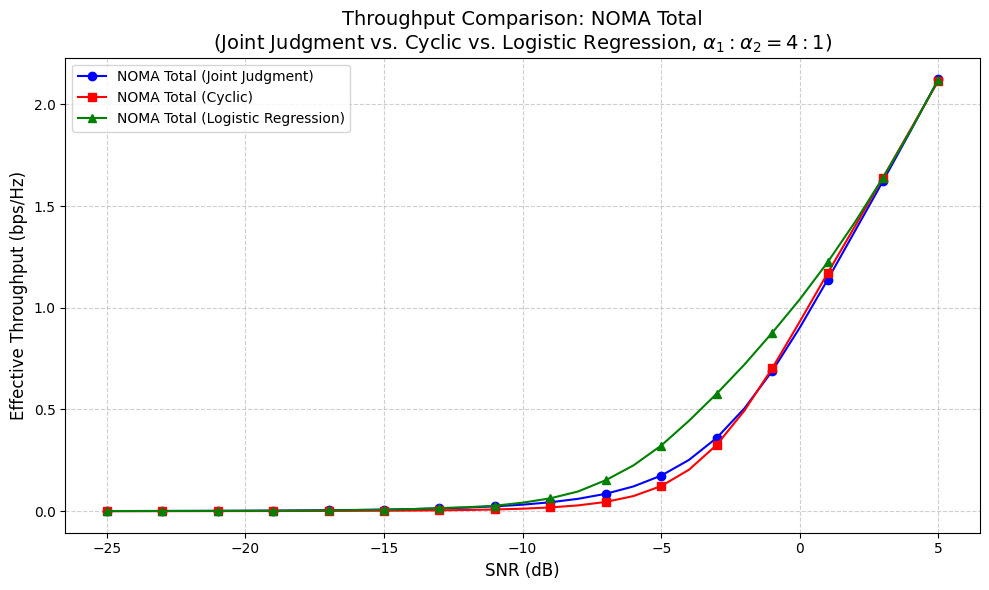

In [11]:
# ---------------------
# 7) Plot Results
# ---------------------
window_length = 7
polyorder = 2

def smooth(data):
    return savgol_filter(data, window_length=window_length, polyorder=polyorder)

th_noma_total_joint_s = smooth(th_noma_total_joint)
th_noma_total_cyclic_s = smooth(th_noma_total_cyclic)
th_noma_total_lr_s = smooth(th_noma_total_lr)

plt.figure(figsize=(10, 6))
plt.plot(SNR_dB, th_noma_total_joint_s, 'b-o', label='NOMA Total (Joint Judgment)', markevery=2)
plt.plot(SNR_dB, th_noma_total_cyclic_s, 'r-s', label='NOMA Total (Cyclic)', markevery=2)
plt.plot(SNR_dB, th_noma_total_lr_s, 'g-^', label='NOMA Total (Logistic Regression)', markevery=2)
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Effective Throughput (bps/Hz)', fontsize=12)
plt.title('Throughput Comparison: NOMA Total\n(Joint Judgment vs. Cyclic vs. Logistic Regression, $\\alpha_1 : \\alpha_2 = 4:1$)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('noma_throughput_comparison_smooth.png', dpi=300)
plt.show()


In [10]:
# ---------------------
# 8) Analysis at 0 dB
# ---------------------
idx_0dB = np.where(SNR_dB == 0)[0][0]
print("\nThroughput Analysis at SNR = 0 dB:")
print(f"NOMA Total (Joint Judgment): {th_noma_total_joint[idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Cyclic): {th_noma_total_cyclic[idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Logistic Regression): {th_noma_total_lr[idx_0dB]:.4f} bps/Hz")



Throughput Analysis at SNR = 0 dB:
NOMA Total (Joint Judgment): 0.9021 bps/Hz
NOMA Total (Cyclic): 0.9365 bps/Hz
NOMA Total (Logistic Regression): 1.0416 bps/Hz
